# Summary
This is the code for the preprocessing of the 3d images with mask labels.  
So only apply preprocessing for the images that have labels (206 samples among about 3700 total samples).

# Libraries

In [1]:
from tqdm import tqdm
import torch
from torchvision import transforms
import sys
from glob import glob
import gc
import os
import pandas as pd
import numpy as np
import scipy as sp
import cv2
from matplotlib import pyplot as plt
import pydicom
import dicomsdl
from joblib import Parallel, delayed
import pickle
import gzip
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from multiprocessing import Pool
import nibabel as nib

# Parameters

In [2]:
BASE_PATH  = './kaggle/input/rsna-2023-abdominal-trauma-detection'
TRAIN_PATH = f'{BASE_PATH}/train_images'
DATA_PATH = f'{BASE_PATH}/3d_preprocessed'

if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)

RESOL = 160
# RESOL = 128
N_FOLDS  = 5
N_PREPROCESS_CHUNKS = 12

PREPROC_NORM_OR_STD = False # True: normalization, False: standardization

train_df = pd.read_csv(f'{BASE_PATH}/train.csv')
train_df = train_df.sort_values(by=['patient_id'])

# Mask related parameters
# Order 1: Bowel, 2: left kidney, 3: right kidney, 4: liver, 5: spleen
MASK_ORDER = [5, 3, 4, 1, 2]

BASE_PATH = './kaggle/input/rsna-2023-abdominal-trauma-detection'
MASK_SAVE_PATH = f'{BASE_PATH}/mask_preprocessed'

if not os.path.isdir(MASK_SAVE_PATH):
    os.mkdir(MASK_SAVE_PATH)
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


device(type='cuda')

# Path definition
## For the 3D images

In [3]:
train_df = pd.read_csv(f'{BASE_PATH}/train.csv')
train_meta = pd.read_csv(f'{BASE_PATH}/train_series_meta.csv')
train_df = train_df.sort_values(by=['patient_id'])
train_df

TRAIN_PATH = BASE_PATH + "/train_images/"
n_chunk = 8
patients = os.listdir(TRAIN_PATH)
n_patients = len(patients)
rng_patients = np.linspace(0, n_patients+1, n_chunk+1, dtype = int)
patients_cts = glob(f'{TRAIN_PATH}/*/*')
n_cts = len(patients_cts)
patients_cts_arr = np.zeros((n_cts, 2), int)
data_paths=[]
for i in range(0, n_cts):
    patient, ct = patients_cts[i].split('/')[-2:]
    patients_cts_arr[i] = patient, ct
    data_paths.append(f'{BASE_PATH}/3d_preprocessed/{patients_cts_arr[i,0]}_{patients_cts_arr[i,1]}.pkl')
TRAIN_IMG_PATH = BASE_PATH + '/processed' 

#Generate tables for training
train_meta_df = pd.DataFrame(patients_cts_arr, columns = ['patient_id', 'series'])

#5-fold splitting
train_df['fold'] = 0
labels = train_df[['bowel_healthy','bowel_injury',
                    'extravasation_healthy','extravasation_injury',
                    'kidney_healthy','kidney_low','kidney_high',
                    'liver_healthy','liver_low','liver_high',
                    'spleen_healthy','spleen_low','spleen_high',
                    'any_injury']].to_numpy()

mskf = MultilabelStratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=0)
counter = 0
for train_index, test_index in mskf.split(np.ones(len(train_df)), labels):
    for i in range(0, len(test_index)):
        train_df['fold'][test_index[i]] = counter
    counter+=1

train_meta_df = train_meta_df.join(train_df.set_index('patient_id'), on='patient_id')
train_meta_df['path']=data_paths

## For the masks

In [4]:
#Segmentation mask part
img_list = glob(f'{BASE_PATH}/train_images/*/*')

#To know which mask belongs to which patients
series_to_patient_dict = {}
for i in range(0, len(img_list)):
    tmp = img_list[i].split('/')
    series_to_patient_dict[int(tmp[-1])] = int(tmp[-2])

seg_path_list = glob(f'{BASE_PATH}/segmentations/*')
seg_info_arr = np.zeros((len(seg_path_list), 2), int)
for i in range(0, len(seg_path_list)):
    series  = int(seg_path_list[i].split('/')[-1][:-4])
    patient = series_to_patient_dict[series]
    seg_info_arr[i,0] = patient
    seg_info_arr[i,1] = series

seg_info_df = pd.DataFrame(seg_info_arr, columns = ['patient_id', 'series'])
seg_info_df['mask_path'] = ''
mask_paths = []
for i in range(0, len(seg_info_df)):
    row = seg_info_df.iloc[i]
    patient_id = row['patient_id']
    series = row['series']
    mask_paths.append(f'{MASK_SAVE_PATH}/{patient_id}_{series}.pkl')
seg_info_df['mask_path'] = mask_paths

#train_meta_df = pd.read_csv(f'{BASE_PATH}/train_meta.csv')
seg_info_df['img_path'] = ''
img_paths = []
for i in tqdm(range(0, len(seg_info_df))):
    row = seg_info_df.iloc[i]
    patient_id = row['patient_id']
    series     = row['series']
    train_img_path = train_meta_df.loc[(train_meta_df['patient_id']==patient_id)&(train_meta_df['series']==series), 'path']
    img_paths.append(train_img_path.iloc[0])
    
    gc.collect()

seg_info_df['img_path'] = img_paths
seg_info_df.to_csv(f'{BASE_PATH}/seg_info.csv', index = False)    

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:12<00:00, 17.02it/s]


# Preprocess input dcm slices to 3d images

In [5]:
def compress(name, data):
    with gzip.open(name, 'wb') as f:
        pickle.dump(data, f)

def decompress(name):
    with gzip.open(name, 'rb') as f:
        data = pickle.load(f)
    return data

In [6]:
#Returns GPU array
def standardize_pixel_array(pixel_array, dcm_rows):
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    for z in range(0, len(pixel_array)):
        if int(dcm_rows[z]['PixelRepresentation']) == 1:
            bit_shift = dcm_rows[z]['BitsAllocated'] - dcm_rows[z]['BitsStored']
            dtype = pixel_array[z].dtype 
            pixel_array[z] = (pixel_array[z] << bit_shift).astype(dtype) >>  bit_shift

    pixel_array = torch.from_numpy(pixel_array.astype(np.float16)).to(DEVICE).to(torch.float16)    

    for z in range(0, len(pixel_array)):
        intercept = float(dcm_rows[z]['RescaleIntercept'])
        slope = float(dcm_rows[z]['RescaleSlope'])
        center = int(dcm_rows[z]['WindowCenter'])
        width = int(dcm_rows[z]['WindowWidth'])
        low = center - width / 2
        high = center + width / 2    
        
        pixel_array[z] = (pixel_array[z] * slope) + intercept
        pixel_array[z] = torch.clip(pixel_array[z], low, high)
        
    gc.collect()    
    return pixel_array

In [7]:
def resize_norm_or_std(data, resol, is_norm = PREPROC_NORM_OR_STD):  
    #resize xy
    data = transforms.Resize((resol, resol), antialias = True)(data)
    
    #zyx to xzy
    data = torch.permute(data, (2, 0, 1))
    #Resize yz
    data = transforms.Resize((resol, resol), antialias = True)(data)
    #xzy to zyx
    data = torch.permute(data, (1, 2, 0))

    if is_norm:
        bottom = torch.min(data)
        data -= bottom
        top    = torch.max(data)
        data/=top
        del top, bottom
    else:
        avg = torch.mean(data, (0, 1, 2))
        std = torch.std(data, (0, 1, 2))
        data = (data-avg)/std
        del avg, std

    gc.collect()
    torch.cuda.empty_cache()
    return data

# Read each slice and stack them to make 3d data
def process_3d(save_path, data_path = TRAIN_PATH):
    tmp = save_path.split('/')[-1][:-4]
    tmp = tmp.split('_')
    patient, study = int(tmp[0]), int(tmp[1])
    imgs = {}    
    
    # To load only needed slices
    imgs = {}    
    for f in sorted(glob(data_path + f'/{patient}/{study}/*.dcm')):  
        pos_z = -int((f.split('/')[-1])[:-4])
        imgs[pos_z] = f
        
    sample_z = np.linspace(0, len(imgs)-1, RESOL, dtype=int)
    dcm_rows = []
    imgs_3d  = []
    for i, k in enumerate(sorted(imgs.keys())):
        if not np.isin([i], sample_z)[0]:
            continue        
        f= imgs[k]
        opened_dicom = dicomsdl.open(f)
        img = opened_dicom.pixelData(storedvalue=True)
        params = opened_dicom.getPixelDataInfo()
        
        imgs_3d.append(img[None])
        dcm_rows.append(params)

    imgs_3d = np.vstack(imgs_3d)
    imgs_3d = standardize_pixel_array(imgs_3d, dcm_rows)
    
    min_imgs = torch.min(imgs_3d)
    max_imgs = torch.max(imgs_3d)
        
    imgs_3d = ((imgs_3d - min_imgs) / (max_imgs - min_imgs + 1e-6))

    if str(dcm_rows[0]['PhotometricInterpretation']) == "MONOCHROME1":
        imgs_3d = 1.0 - imgs_3d

    imgs_3d = resize_norm_or_std(imgs_3d, RESOL).to('cpu')

    #Save the image
    compress(save_path, imgs_3d)                      

    del imgs, img, imgs_3d
    gc.collect()
    torch.cuda.empty_cache()

In [8]:
# Preprocess dataset
rng_samples = np.linspace(0, len(train_meta_df), N_PREPROCESS_CHUNKS+1, dtype = int)
def process_3d_wrapper(process_ind, rng_samples = rng_samples, df = train_meta_df):
    for i in tqdm(range(rng_samples[process_ind], rng_samples[process_ind+1])):
        process_3d(df.iloc[i]['path'])

In [9]:
%%time
Parallel(n_jobs = N_PREPROCESS_CHUNKS)(delayed(process_3d_wrapper)(i) for i in range(N_PREPROCESS_CHUNKS))

100%|█████████▉| 391/392 [06:20<00:00,  1.30it/s]

CPU times: user 2.1 s, sys: 450 ms, total: 2.56 s
Wall time: 6min 22s


100%|██████████| 392/392 [06:21<00:00,  1.03it/s]


[None, None, None, None, None, None, None, None, None, None, None, None]

# Preprocess masks to 3d dataset

In [10]:
def create_3D_segmentations(filepath, downsample_rate=2):
    img = nib.load(filepath).get_fdata()
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [1, 0, 2])
    img = np.flip(img, 0)

    if(len(img)>256):
        img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    else:
        img = img[:,::downsample_rate, ::downsample_rate]
    return img

def img_to_masks(img, mask_order  = MASK_ORDER):
    imgs_stack = []    
    for i in range(0, len(mask_order)):
        one_mask = (img==mask_order[i]).astype(np.uint8)
        imgs_stack.append(one_mask[None])

    imgs_stack = np.vstack(imgs_stack)    
    return imgs_stack

def resize_3d(img, resol = RESOL):
    imgs_stack = []
    for i in range(0, len(img)):
        imgs_stack.append(cv2.resize(img[i], (resol, resol))[None])
    imgs_stack = np.vstack(imgs_stack)

    resized_img = np.zeros((resol, resol, resol), np.uint8)
    for i in range(0, len(imgs_stack[0,0])):
        resized_img[:,:,i] = cv2.resize(imgs_stack[:,:,i], (resol, resol))
    del imgs_stack
    gc.collect()
    return resized_img

def process_mask(path, resol = RESOL):
    series = path.split('/')[-1].split('_')[-1][:-4]
    origin_mask_path = f'{BASE_PATH}/segmentations/{series}.nii'
    img_3d = create_3D_segmentations(origin_mask_path)
    mask_3d = img_to_masks(img_3d)    
    resized_mask_3d = np.zeros((len(mask_3d), resol, resol, resol), np.uint8)
    for i in range(0, len(MASK_ORDER)):
        resized_mask_3d[i] = resize_3d(mask_3d[i])
    compress(path, resized_mask_3d)
    del img_3d, mask_3d, resized_mask_3d
    gc.collect()
    

In [11]:
# Preprocess dataset
rng_samples = np.linspace(0, len(seg_info_df), N_PREPROCESS_CHUNKS+1, dtype = int)
def process_3d_wrapper(process_ind, rng_samples = rng_samples, seg_info_df = seg_info_df):
    for i in tqdm(range(rng_samples[process_ind], rng_samples[process_ind+1])):
        process_mask(seg_info_df.iloc[i]['mask_path'])

In [12]:
%%time
Parallel(n_jobs = N_PREPROCESS_CHUNKS)(delayed(process_3d_wrapper)(i) for i in range(N_PREPROCESS_CHUNKS))

100%|██████████| 18/18 [00:48<00:00,  2.70s/it]


CPU times: user 261 ms, sys: 69.4 ms, total: 331 ms
Wall time: 49.3 s


100%|██████████| 17/17 [00:49<00:00,  2.89s/it]


[None, None, None, None, None, None, None, None, None, None, None, None]

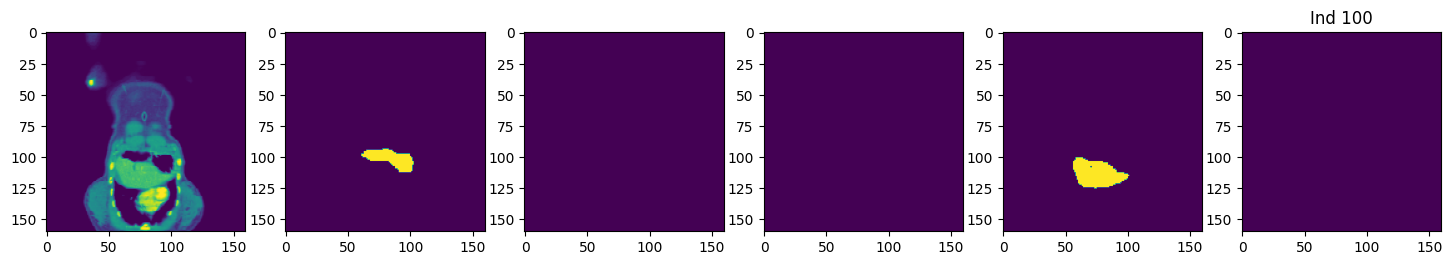

In [13]:
seg_info_df = pd.read_csv(f'{BASE_PATH}/seg_info.csv')

for i in range(0, len(seg_info_df)):
    if (i !=100):
        continue
    row = seg_info_df.iloc[i]
    img_3d = decompress(row['img_path'])
    mask   = decompress(row['mask_path'])
    f, axs = plt.subplots(1, 6, figsize=(18, 3))
    plt.title(f'Ind {i}')
    axs[0].imshow(img_3d[:,64,:])
    for j in range(0, 5):
        axs[j+1].imshow(mask[j,:,64,:])
